## Final Project Submission

Please fill out:
* Student name: Neha Patel
* Student pace: part time
* Scheduled project review date/time: 10/10/2020, 2:30 pm CST
* Instructor name: James Irving
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!

## Business Case

## Methodology

## Import Necessary Libraries

In [64]:
# Importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn import metrics

## Exploring Data

In [3]:
#Loading the dataset
df = pd.read_csv('training_data.csv')
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [4]:
#Exploring the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
Facies       3232 non-null int64
Formation    3232 non-null object
Well Name    3232 non-null object
Depth        3232 non-null float64
GR           3232 non-null float64
ILD_log10    3232 non-null float64
DeltaPHI     3232 non-null float64
PHIND        3232 non-null float64
PE           3232 non-null float64
NM_M         3232 non-null int64
RELPOS       3232 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.9+ KB


### Nulls
It looks like there are no null values in the dataset. Although, just to be extra sure, we use `df.isna().sum()`

In [6]:
df.isna().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

### Duplicates

In [7]:
df[df.duplicated()]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
302,8,B5 LM,SHRIMPLIN,2944.0,234.8,0.515,4.7,11.41,4.8,2,0.4


In [8]:
df[df.duplicated(keep=False)]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
301,8,B5 LM,SHRIMPLIN,2944.0,234.8,0.515,4.7,11.41,4.8,2,0.4
302,8,B5 LM,SHRIMPLIN,2944.0,234.8,0.515,4.7,11.41,4.8,2,0.4


While one duplicate row wouldn't affect our model, however, we would like to remove it to avoid the slightest possibility of bias.

In [9]:
#Removing the duplicate entry
df.drop_duplicates(inplace = True)

In [10]:
#Check
df.loc[df.index[301:303]]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
301,8,B5 LM,SHRIMPLIN,2944.0,234.80,0.515,4.7,11.410,4.8,2,0.40
303,8,B5 LM,SHRIMPLIN,2944.5,273.48,0.538,5.3,10.045,5.1,2,0.35


### Evaluating Categorical and Numerical Features

In [11]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,4.420922,2875.803466,66.083567,0.642759,3.559289,13.483855,3.724681,1.498298,0.520325
std,2.503839,131.021059,30.716527,0.241872,5.229719,7.700085,0.896091,0.500074,0.286829
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.914500,0.492500,1.162500,8.343500,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.700000,0.624591,3.500000,12.150000,3.551000,1.000000,0.526000
75%,6.000000,2980.000000,79.625000,0.812823,6.436000,16.457500,4.300000,2.000000,0.767500
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [12]:
#trials for building a function
df.Depth.dtype == 'int64' or df.Depth.dtype == 'float64'

True

In [13]:
def column_type_exploration(df, column):
    
    '''For a given column in the given dataframe, displays an output of number of unique values and
    statistical summary for number type
    -----------------------------------------------
    Input:
    df (DataFrame): DataFrame for the column to evaluate
    column (str): column name
    -----------------------------------------------
    Output:
    statistical summary of the numerical column
    unique value counts'''
    
    if df[column].dtype=='int64' or df[column].dtype=='float64':
        display(df[column].describe())
    
    print('\n')
    print(f'Number of Unique Values: {len(df[column].unique())}')
    print('\n')
    print(f'Example Unique Values: {df[column].unique()[:5]}')
    

In [14]:
#Test the function
column_type_exploration(df,'Depth')

count    3231.000000
mean     2875.803466
std       131.021059
min      2573.500000
25%      2791.000000
50%      2893.500000
75%      2980.000000
max      3122.500000
Name: Depth, dtype: float64



Number of Unique Values: 1099


Example Unique Values: [2793.  2793.5 2794.  2794.5 2795. ]


In [15]:
#exploring all columns
index = 1
for column in df.columns:
    print(f'{index}. {column.upper()}:')
#     print('\n')
    column_type_exploration(df,column)
    print('\n')
    print('--'*40)
    print('\n')
    index+=1

1. FACIES:


count    3231.000000
mean        4.420922
std         2.503839
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Facies, dtype: float64



Number of Unique Values: 9


Example Unique Values: [3 2 8 6 7]


--------------------------------------------------------------------------------


2. FORMATION:


Number of Unique Values: 14


Example Unique Values: ['A1 SH' 'A1 LM' 'B1 SH' 'B1 LM' 'B2 SH']


--------------------------------------------------------------------------------


3. WELL NAME:


Number of Unique Values: 8


Example Unique Values: ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN']


--------------------------------------------------------------------------------


4. DEPTH:


count    3231.000000
mean     2875.803466
std       131.021059
min      2573.500000
25%      2791.000000
50%      2893.500000
75%      2980.000000
max      3122.500000
Name: Depth, dtype: float64



Number of Unique Values: 1099


Example Unique Values: [2793.  2793.5 2794.  2794.5 2795. ]


--------------------------------------------------------------------------------


5. GR:


count    3231.000000
mean       66.083567
std        30.716527
min        13.250000
25%        46.914500
50%        65.700000
75%        79.625000
max       361.150000
Name: GR, dtype: float64



Number of Unique Values: 2776


Example Unique Values: [77.45 78.26 79.05 86.1  74.58]


--------------------------------------------------------------------------------


6. ILD_LOG10:


count    3231.000000
mean        0.642759
std         0.241872
min        -0.025949
25%         0.492500
50%         0.624591
75%         0.812823
max         1.480000
Name: ILD_log10, dtype: float64



Number of Unique Values: 1276


Example Unique Values: [0.664 0.661 0.658 0.655 0.647]


--------------------------------------------------------------------------------


7. DELTAPHI:


count    3231.000000
mean        3.559289
std         5.229719
min       -21.832000
25%         1.162500
50%         3.500000
75%         6.436000
max        18.600000
Name: DeltaPHI, dtype: float64



Number of Unique Values: 1055


Example Unique Values: [ 9.9 14.2 14.8 13.9 13.5]


--------------------------------------------------------------------------------


8. PHIND:


count    3231.000000
mean       13.483855
std         7.700085
min         0.550000
25%         8.343500
50%        12.150000
75%        16.457500
max        84.400000
Name: PHIND, dtype: float64



Number of Unique Values: 1949


Example Unique Values: [11.915 12.565 13.05  13.115 13.3  ]


--------------------------------------------------------------------------------


9. PE:


count    3231.000000
mean        3.724681
std         0.896091
min         0.200000
25%         3.100000
50%         3.551000
75%         4.300000
max         8.094000
Name: PE, dtype: float64



Number of Unique Values: 995


Example Unique Values: [4.6 4.1 3.6 3.5 3.4]


--------------------------------------------------------------------------------


10. NM_M:


count    3231.000000
mean        1.498298
std         0.500074
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: NM_M, dtype: float64



Number of Unique Values: 2


Example Unique Values: [1 2]


--------------------------------------------------------------------------------


11. RELPOS:


count    3231.000000
mean        0.520325
std         0.286829
min         0.010000
25%         0.273000
50%         0.526000
75%         0.767500
max         1.000000
Name: RELPOS, dtype: float64



Number of Unique Values: 825


Example Unique Values: [1.    0.979 0.957 0.936 0.915]


--------------------------------------------------------------------------------




In [16]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

With Facies being our target variable, we divide the rest of the columns into categorical or numerical type

In [17]:
categorical = ['Formation','Well Name','NM_M']
numerical = ['Depth','GR','ILD_log10','DeltaPHI','PHIND','PE','RELPOS']

#### Exploring Categorical Values

In [18]:
index = 1
for column in categorical:
    print(f'{index}. {column.upper()}:')
    if df[column].dtype == 'object':
        display(df[column].unique())
    else:
        display(df[column].sort_values().unique())
    print('--'*40)
    index+=1

1. FORMATION:


array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM'],
      dtype=object)

--------------------------------------------------------------------------------
2. WELL NAME:


array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

--------------------------------------------------------------------------------
3. NM_M:


array([1, 2], dtype=int64)

--------------------------------------------------------------------------------


### Exploring Target Variable

In [19]:
df.Facies.sort_values().unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### Visual Analysis

C:\Users\19035\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\19035\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\19035\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\19035\Anaco

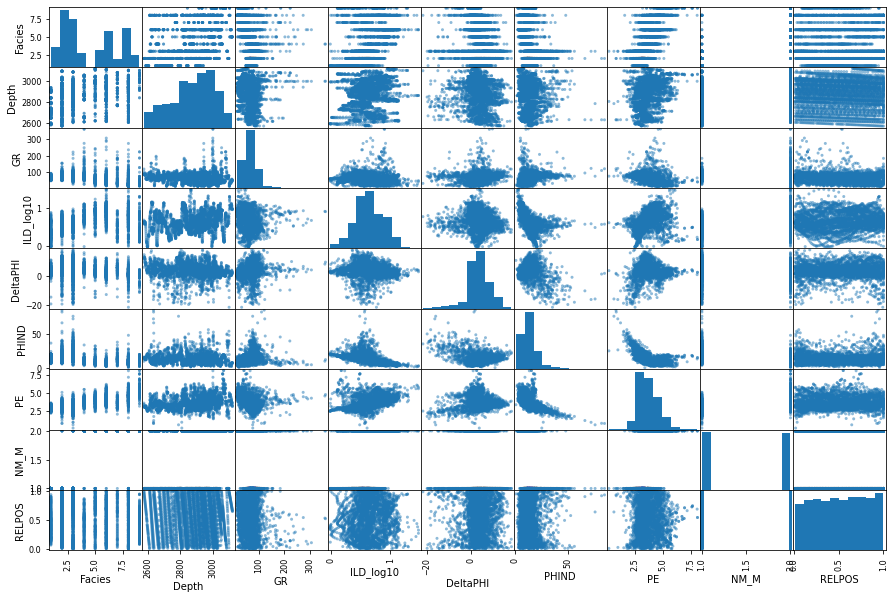

In [20]:
#visualizing a scatter matrix
pd.plotting.scatter_matrix(df,figsize=(15,10));

In [21]:
#Verifying the integer categorical and numerical columns
categorical

['Formation', 'Well Name', 'NM_M']

Depth - check
GR - check
ILD_log10 - check
DeltaPHI - check
PHIND - check
PE - check
RELPOS - check


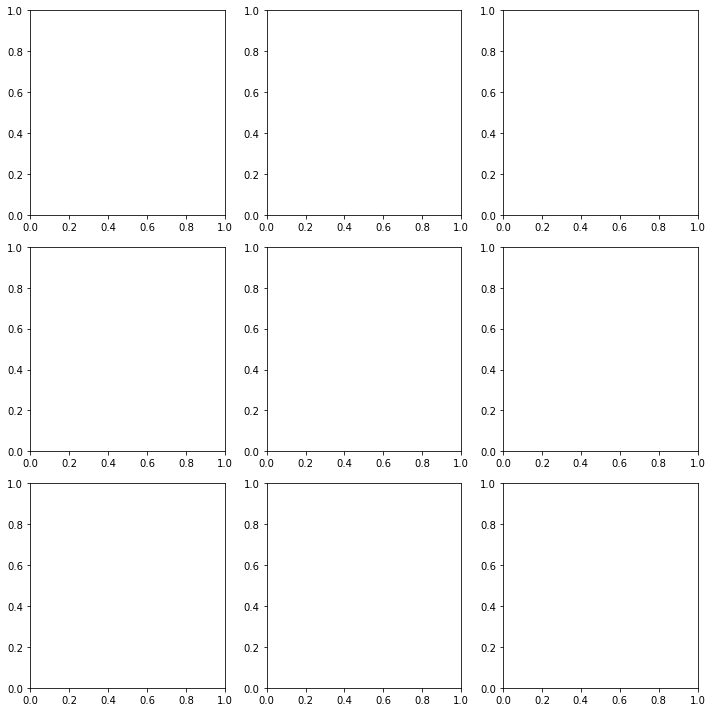

In [22]:
#testing for any basic relation of numerical columns with the target variable
fig,axes = plt.subplots(ncols = 3, nrows = 3, figsize =(10,10))
axes=axes.flatten()
for i,col in enumerate(numerical):
    try:
        sns.scatterplot(x=col, y='Facies', data=df, ax = axes[i], palette=color_palette);
    except:
        print(f'{col} - check')
plt.tight_layout()

### Class Imbalance

,Facies
2,22.8412
3,19.0344
8,15.3822
6,14.299
1,8.01609
5,6.71619
4,5.69483
9,4.98298
7,3.03312


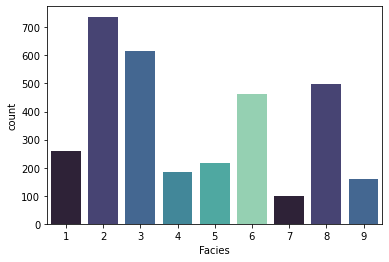

In [23]:
# Detecting class imbalance
color_palette = sns.color_palette("mako")
sns.countplot('Facies', data = df, palette=color_palette);
display((df.Facies.value_counts(normalize = True)*100).to_frame().style.background_gradient())

## Train Test Split

In [24]:
y = df.Facies
X = df.copy().drop('Facies', axis = 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7)

### Class Imbalance

,Facies
2,22.7404
3,19.026
8,15.6005
6,14.3211
1,7.67643
5,6.85101
4,5.69542
9,5.03508
7,3.05407


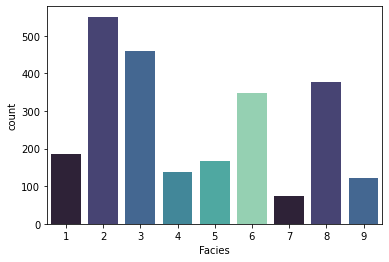

In [26]:
color_palette = sns.color_palette("mako")
sns.countplot(y_train, palette=color_palette);
display((y_train.value_counts(normalize = True)*100).to_frame().style.background_gradient())

## Preprocessing

### Filling The Null Values

Although there aren't any null values in this dataset, there are chances of having some while this model is used at the users end. It is therefore paramount to consider and accommodate for the possible null values.

In [27]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [28]:
num_imputer = KNNImputer(weights='distance') #parameter: copy = True/False?
cat_imputer = KNNImputer(weights='distance')

### Scaling Numerical Columns

Exploring the numerical data to select the best scaler, and then applying the appropriate scaling method.

In [29]:
df[numerical]

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,RELPOS
0,2793.0,77.450,0.664,9.900,11.915,4.600,1.000
1,2793.5,78.260,0.661,14.200,12.565,4.100,0.979
2,2794.0,79.050,0.658,14.800,13.050,3.600,0.957
3,2794.5,86.100,0.655,13.900,13.115,3.500,0.936
4,2795.0,74.580,0.647,13.500,13.300,3.400,0.915
...,...,...,...,...,...,...,...
3227,3120.5,46.719,0.947,1.828,7.254,3.617,0.685
3228,3121.0,44.563,0.953,2.241,8.013,3.344,0.677
3229,3121.5,49.719,0.964,2.925,8.013,3.190,0.669
3230,3122.0,51.469,0.965,3.083,7.708,3.152,0.661


**Visualizations to select scaling method:**

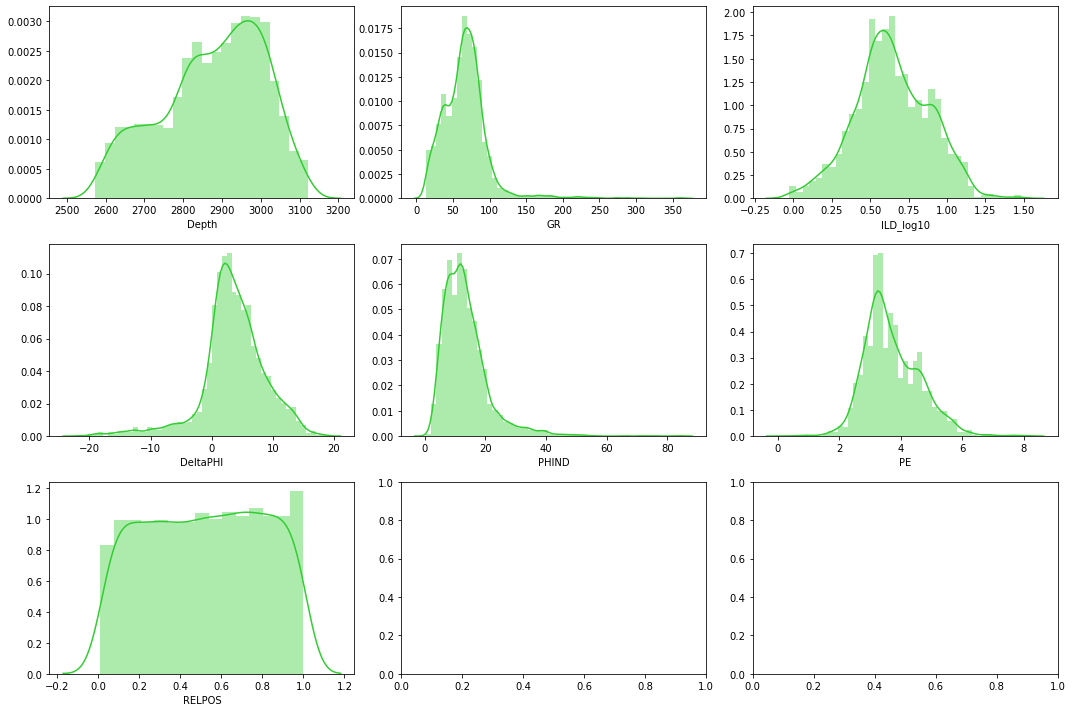

In [30]:
fig,axes = plt.subplots(ncols = 3, nrows = 3, figsize =(15,10))
axes=axes.flatten()
for i,col in enumerate(numerical):
    try:
        sns.distplot(df[col], ax = axes[i], color = '#32CD32');
    except:
        print(f'{col} - check')
plt.tight_layout()

Robust scaler will work for all, .........RELPOS???, quantile transformer/power?

In [31]:
from sklearn.preprocessing import QuantileTransformer

### One Hot Encoding the Categorical Columns

In [32]:
encoder = OneHotEncoder(sparse=False, drop = 'first')

In [33]:
#Test
X_train_ohe_trial = encoder.fit_transform(X_train[categorical])
display(encoder.get_feature_names(categorical))
pd.DataFrame(X_train_ohe_trial, columns=encoder.get_feature_names(categorical))

array(['Formation_A1 SH', 'Formation_B1 LM', 'Formation_B1 SH',
       'Formation_B2 LM', 'Formation_B2 SH', 'Formation_B3 LM',
       'Formation_B3 SH', 'Formation_B4 LM', 'Formation_B4 SH',
       'Formation_B5 LM', 'Formation_B5 SH', 'Formation_C LM',
       'Formation_C SH', 'Well Name_CROSS H CATTLE', 'Well Name_LUKE G U',
       'Well Name_NEWBY', 'Well Name_NOLAN', 'Well Name_Recruit F9',
       'Well Name_SHANKLE', 'Well Name_SHRIMPLIN', 'NM_M_2'], dtype=object)

,Formation_A1 SH,Formation_B1 LM,Formation_B1 SH,Formation_B2 LM,Formation_B2 SH,Formation_B3 LM,Formation_B3 SH,Formation_B4 LM,Formation_B4 SH,Formation_B5 LM,...,Formation_C LM,Formation_C SH,Well Name_CROSS H CATTLE,Well Name_LUKE G U,Well Name_NEWBY,Well Name_NOLAN,Well Name_Recruit F9,Well Name_SHANKLE,Well Name_SHRIMPLIN,NM_M_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2419,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pipelines

In [34]:
set_config(display='diagram')

#### Preprocessing

In [35]:
cat_transformer = Pipeline(steps=[('impute', KNNImputer(weights='distance')),
                                  ('ohe', OneHotEncoder(sparse=False, drop='first',handle_unknown='ignore'))])

In [36]:
num_transformer = Pipeline(steps=[('impute', KNNImputer(weights='distance')),
                                  ('scaler', RobustScaler())])

In [37]:
preprocessing = ColumnTransformer(transformers=[('num', num_transformer,numerical),
                                                ('cat', cat_transformer,categorical)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  KNNImputer(weights='distance')),
                                                 ('scaler', RobustScaler())]),
                                 ['Depth', 'GR', 'ILD_log10', 'DeltaPHI',
                                  'PHIND', 'PE', 'RELPOS']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  KNNImputer(weights='distance')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Formation', 'Well Name', 'NM_M'])])

In [47]:
def preprocessing(num_cols, cat_cols,
                  cat_imputer=KNNImputer(weights='distance'), 
                  encoder=OneHotEncoder(sparse=False, drop='first',handle_unknown='ignore'), 
                  num_imputer=KNNImputer(weights='distance'), 
                  transformation=PowerTransformer()):
    
    '''Builds a preprocessing pipeline and column transformation to data containing numerical and/or categorical data 
    based on the chosen classes/preprocessing methods
    --------------------------------
    Inputs:
    
    cat_imputer (class): Imputer class for categorical data. Default - KNNImputer() with weights as distance
    encoder (class): encoding class for categorical data. Default - OneHotEncoder() ignoring the unknowns and dropping first
    num_imputer (class): Imputer class for numerical data. Default - KNNImputer() with weights as distance
    transformation (class): linear scaling or non-linear transformation class. Default - PowerTransformer()
    num_cols (list): numerical columns
    cat_cols (list): categorical columns
    --------------------------------
    Output:
    
    ColumnTransformer pipeline to preprocess a given data
    --------------------------------'''
    
    cat_transformer = Pipeline(steps=[('impute', cat_imputer),
                                  ('ohe', encoder)])
    
    num_transformer = Pipeline(steps=[('impute', num_imputer),
                                  ('scaler', transformation)])
    
    preprocessing = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                                ('cat', cat_transformer,cat_cols)])
    return preprocessing

In [48]:
preprocessing(numerical, categorical, transformation=RobustScaler())

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  KNNImputer(weights='distance')),
                                                 ('scaler', RobustScaler())]),
                                 ['Depth', 'GR', 'ILD_log10', 'DeltaPHI',
                                  'PHIND', 'PE', 'RELPOS']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  KNNImputer(weights='distance')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Formation', 'Well Name', 'NM_M'])])

In [58]:
def preprocessing_trial(num_cols, cat_cols,
                  cat_imputer=KNNImputer(weights='distance'), 
                  encoder=OneHotEncoder(sparse=False, drop='first',handle_unknown='error'), 
                  num_imputer=KNNImputer(weights='distance'), 
                  transformation=PowerTransformer()):
    
    '''Builds a preprocessing pipeline and column transformation to data containing numerical and/or categorical data 
    based on the chosen classes/preprocessing methods
    --------------------------------
    Inputs:
    
    cat_imputer (class): Imputer class for categorical data. Default - KNNImputer() with weights as distance
    encoder (class): encoding class for categorical data. Default - OneHotEncoder() ignoring the unknowns and dropping first
    num_imputer (class): Imputer class for numerical data. Default - KNNImputer() with weights as distance
    transformation (class): linear scaling or non-linear transformation class. Default - PowerTransformer()
    num_cols (list): numerical columns
    cat_cols (list): categorical columns
    --------------------------------
    Output:
    
    ColumnTransformer pipeline to preprocess a given data
    --------------------------------'''
    
    cat_transformer = Pipeline(steps=[('ohe', encoder),
                                      ('impute', cat_imputer)])
    
    num_transformer = Pipeline(steps=[('impute', num_imputer),
                                  ('scaler', transformation)])
    
    preprocessing = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                                ('cat', cat_transformer,cat_cols)])
    return preprocessing

#### Modeling

In [38]:
def model_pipeline(model,preprocessor):
    model = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', model)])
    return model

In [49]:
model_pipeline(KNeighborsRegressor(),preprocessing(numerical, categorical, transformation=RobustScaler()))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(weights='distance')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Depth', 'GR', 'ILD_log10',
                                                   'DeltaPHI', 'PHIND', 'PE',
                                                   'RELPOS']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(weights='distance')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Formation', 'Well Name',
                                                   'NM_M'])])),
                ('model', KNeighborsRegressor())])

## Train Validation Split

In [40]:
X_train_model, X_validation, y_train_model, y_validation = train_test_split(X_train, y_train, random_state = 7)

## Base Model - KNN

Since the nature of the dataset is such that most of the immediate data points in depth have the same characteristics, except on the boundaries, our best first approach could be using the KNN model.

In [50]:
# Initiate model
knn_model = model_pipeline(KNeighborsClassifier(weights='distance'),
                           preprocessing(numerical,categorical, transformation=RobustScaler()))

#Fit model
knn_model.fit(X_train_model,y_train_model)

ValueError: could not convert string to float: 'B5 LM'

In [59]:
model_pipeline(KNeighborsClassifier(weights='distance'),
                           preprocessing(numerical,categorical, transformation=RobustScaler()))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(weights='distance')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Depth', 'GR', 'ILD_log10',
                                                   'DeltaPHI', 'PHIND', 'PE',
                                                   'RELPOS']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(weights='distance')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Formation', 'Well Name',
                                                   'NM_M'])])),
                ('model', KNeighborsClassifier(weights='distance'))])

In [ ]:
#Predict

In [ ]:
#model analysis

In [ ]:
#gridsearch

In [61]:
# Initiate model
knn_model_trial = model_pipeline(KNeighborsClassifier(weights='distance'),
                           preprocessing_trial(numerical,categorical, transformation=RobustScaler()))

#Fit model
knn_model_trial.fit(X_train_model,y_train_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(weights='distance')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Depth', 'GR', 'ILD_log10',
                                                   'DeltaPHI', 'PHIND', 'PE',
                                                   'RELPOS']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('impute',
                                                                   KNNImputer(weights='distance'))]),
                                                  ['Formation', 'Well Name',
                                                   'NM_M'])])),
                ('model', KNeighborsClassifier(weights='distance'))])

In [62]:
#Predict
y_hat_knn_trial = knn_model_trial.predict(X_validation)

In [69]:
print(metrics.classification_report(y_validation, y_hat_knn_trial))

              precision    recall  f1-score   support

           1       0.84      0.88      0.86        42
           2       0.85      0.83      0.84       150
           3       0.75      0.77      0.76       115
           4       0.63      0.76      0.69        34
           5       0.77      0.75      0.76        36
           6       0.75      0.75      0.75        79
           7       0.79      0.73      0.76        15
           8       0.85      0.78      0.81       105
           9       0.94      0.97      0.95        30

    accuracy                           0.80       606
   macro avg       0.80      0.80      0.80       606
weighted avg       0.80      0.80      0.80       606



In [ ]:
#Evaluation Report

## Decision Tree

## Random Forest

## SVM

## XG Boost

## Results and Interpretations

## Conclusions

## Recommendations

## Future Work